| Status                             | Meaning                         | What it means in your data                                                                         |
| ---------------------------------- | ------------------------------- | -------------------------------------------------------------------------------------------------- |
| **200 OK**                         | Request succeeded               | The page or API endpoint was returned correctly.                                                   |
| **304 Not Modified**               | Cached version is still valid   | The client already had the resource and the server said “no change”. Common for static files.      |
| **302 Found (Temporary Redirect)** | Redirect to another URL         | The server redirected the user (e.g., login, HTTPS redirect, or URL change).                       |
| **404 Not Found**                  | Resource does not exist         | Broken links, missing pages, bad URLs, or crawlers probing random paths.                           |
| **403 Forbidden**                  | Access denied                   | The client is blocked or lacks permission (IP blocked, auth required).                             |
| **500 Internal Server Error**      | Server crashed while processing | Bug, memory error, timeout, or bad backend logic.                                                  |
| **501 Not Implemented**            | Method not supported            | The server doesn’t recognize the request method (e.g., PUT on a server that only allows GET/POST). |
| **400 Bad Request**                | Malformed request               | Invalid syntax, missing parameters, or corrupted requests.                                         |


After Normalized: 

200 -> Success

304 -> No Change

302 -> Redirected

404 -> Not Found

Others -> Error

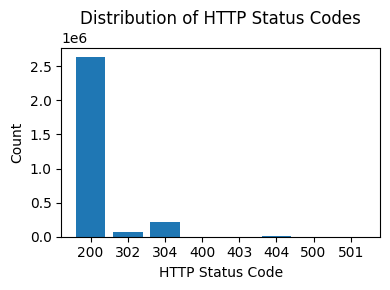

In [52]:
status_counts = df["status"].value_counts().sort_index()

plt.figure(figsize=(4, 3))
plt.bar(status_counts.index.astype(str), status_counts.values)

plt.xlabel("HTTP Status Code")
plt.ylabel("Count")
plt.title("Distribution of HTTP Status Codes")
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd 
import numpy as np
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA 
# from PyEMD.EMD import EMD
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# from shared_functions.gg_sheet_drive import *

In [ ]:
def read_csv(name = 'train', interval = '5min'): # for some random reasons I have to create a read_csv function, nice  ¯\_(ツ)_/¯

    df = pd.read_csv(os.path.join(project_root, 'data', 'processed', f"{name}.csv"))

    df['time'] = pd.to_datetime(df['time'])
    df['status'] = df['status'].astype(int)
    df['size'] = df['size'].astype(float)

    # Time resampling for forecasting
    df_agg = (
        df
        .set_index("time")
        .groupby("status_label")
        .resample(interval, level=0)["size"]
        .sum()
        .reset_index()
        .fillna(0)
    )

    return df, df_agg

train, train_time = read_csv('train')
test, test_time = read_csv('test')

In [6]:
train_time['log_time'] = np.log(train_time['size'])
test_time['log_time'] = np.log(test_time['size'])

train_time['log_time'] = train_time['log_time'].apply(lambda x: 0 if x < 0 else x)
test_time['log_time'] = test_time['log_time'].apply(lambda x: 0 if x < 0 else x)

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
train_time.shape

(75990, 4)

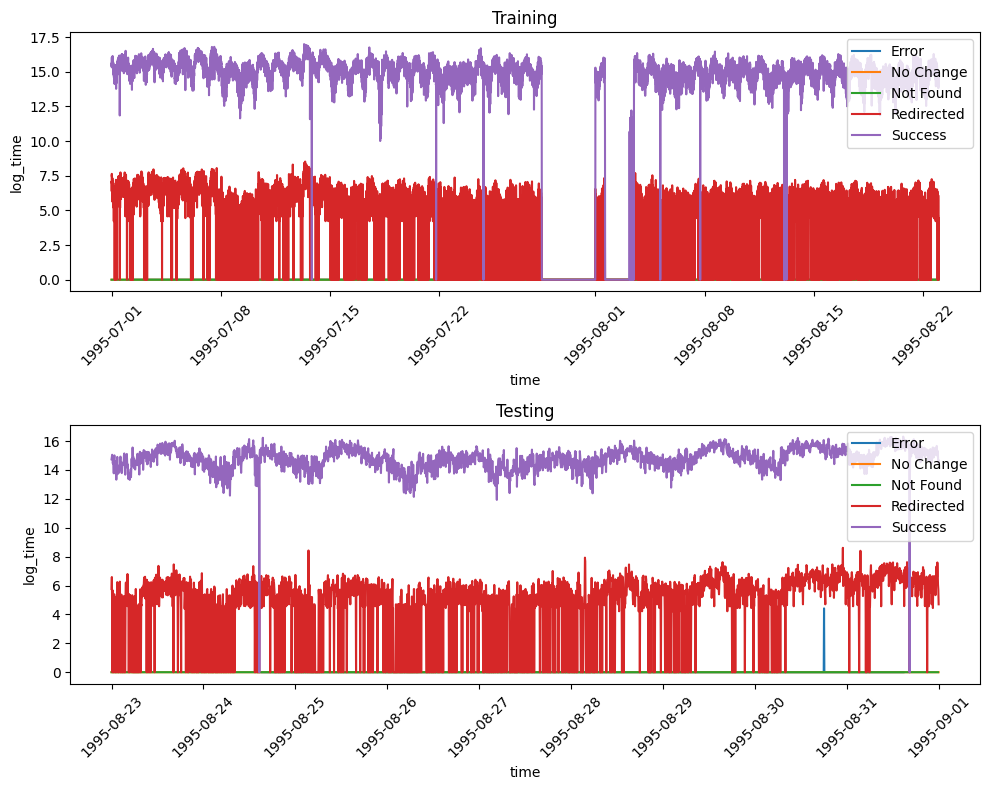

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

sns.lineplot(data=train_time, x="time", y="log_time",
             hue="status_label", ax=axes[0])
axes[0].set_title("Training")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc="upper right")

sns.lineplot(data=test_time, x="time", y="log_time",
             hue="status_label", ax=axes[1])
axes[1].set_title("Testing")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Looks predictable?

#### Forecasting

#### Some ARIMA, SARIMAX might help 

In [25]:
result = adfuller(train_time['size'])

print(f"The ADFuller yields the test statistic {result[0]} and the p-value {result[1]}, which means the series is {'non-' if result[1] > 0.05 else ''}stationary")

The ADFuller yields the test statistic -4.226282246698696 and the p-value 0.0005945586881635197, which means the series is stationary


In [13]:
def acf_pacf(series):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))
    plot_acf(series, ax=axes[0], lags=30, title='ACF')
    plot_pacf(series, ax=axes[1], lags=30, title='PACF')
    axes[0].set_ylim(-0.5, 0.5)
    axes[1].set_ylim(-0.5, 0.5)
    plt.tight_layout()

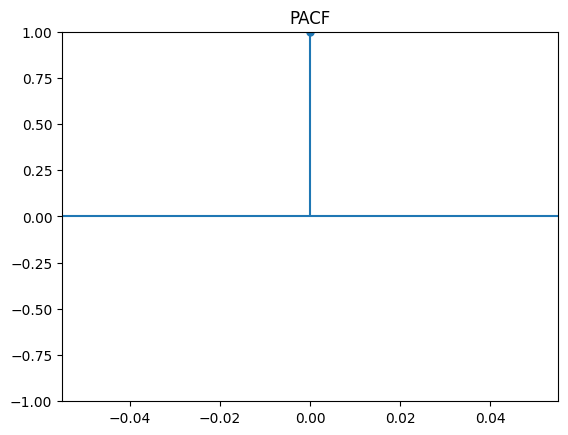

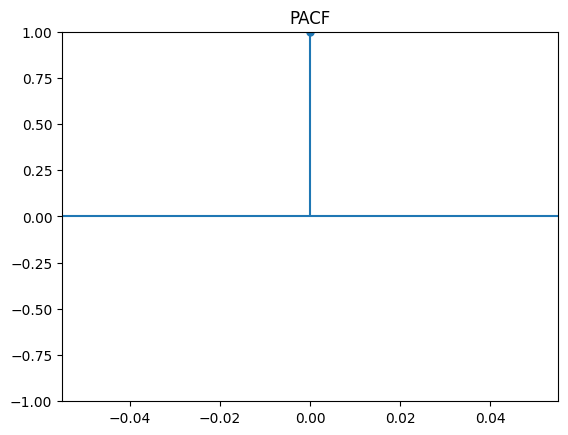

In [26]:
plot_pacf(train['size'], lags=30, title='PACF')

In [28]:
def plot_prediction(train:pd.DataFrame = train, test:pd.DataFrame = test, col:str = 'size', pred:str = None):
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=train[date_col], y=train[col], label='Train')
    sns.lineplot(x=test[date_col], y=test[col], label='Test')
    sns.lineplot(x=test[date_col], y=pred, label='Prediction')
    plt.tight_layout()
    
    y_true = test[col].values
    y_pred = np.asarray(pred)

    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) 
    r2 = r2_score(y_true, y_pred)
    
    print(f'RMSE: {rmse}, MAPE: {mape}, R2: {r2}')

In [29]:
def arima(p,d,q, col): 
    arima = ARIMA(train[col], order=(p, d, q)).fit()

    pred = arima.forecast(steps = len(test))

    plot_prediction(train = train, test = test, col = col, pred = pred)

In [ ]:
arima(1,0,1, col = 'size')

In [9]:
def for_dl_input_lstm(series, window_size=10):
    series = np.asarray(series, dtype=np.float32)
    
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    
    X = np.array(X).reshape(-1, window_size, 1)  # Shape: (samples, window_size, 1) - 3D for LSTM
    y = np.array(y)
    
    return X, y

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden=256, mlp_hidden1=128, mlp_hidden2=64,
        output_size=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden,
        batch_first=True, num_layers=3, dropout=dropout)
        self.mlp = nn.Sequential(
        nn.Linear(lstm_hidden, mlp_hidden1),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden1, mlp_hidden2),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden2, output_size)
        )
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x) # output shape: (batch, seq_len, lstm_hidden)
        last_out = lstm_out[:, -1, :] # take last time step
        return self.mlp(last_out)


In [11]:
X_train, y_train = for_dl_input_lstm(train_time['log_time'], window_size = 12)
X_test, y_test = for_dl_input_lstm(test_time['log_time'], window_size = 12)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [12]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_train_tensor, y_train_tensor)

loader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True
)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [24]:
model = LSTM(input_size=X_train.shape[-1], output_size=1, dropout=0.5).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(50):
    model.train()
    total_loss = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/50", leave=False)

    for Xb, yb in pbar:
        Xb = Xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # update progress bar text
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")

Epoch 1, Avg Loss: 5.2919


Epoch 2, Avg Loss: 2.8724


Epoch 3, Avg Loss: 2.7840


Epoch 4, Avg Loss: 2.7443


Epoch 5, Avg Loss: 2.6141


Epoch 6, Avg Loss: 2.5583


Epoch 7, Avg Loss: 2.5518


Epoch 8, Avg Loss: 2.4366


Epoch 9, Avg Loss: 2.4175


Epoch 10, Avg Loss: 2.3252


Epoch 11, Avg Loss: 2.2924


Epoch 12, Avg Loss: 2.2395


Epoch 13, Avg Loss: 2.1832


Epoch 14, Avg Loss: 2.1563


Epoch 15, Avg Loss: 2.1605


Epoch 16, Avg Loss: 2.1649


Epoch 17, Avg Loss: 2.0761


Epoch 18, Avg Loss: 2.0367


Epoch 19, Avg Loss: 2.0121


Epoch 20, Avg Loss: 2.0285


Epoch 21, Avg Loss: 1.9909


Epoch 22, Avg Loss: 1.9958


Epoch 23, Avg Loss: 1.9614


Epoch 24, Avg Loss: 1.9180


Epoch 25, Avg Loss: 1.9380


Epoch 26, Avg Loss: 1.9032


Epoch 27, Avg Loss: 1.8803


Epoch 28, Avg Loss: 1.8816


Epoch 29, Avg Loss: 1.8593


Epoch 30, Avg Loss: 1.8405


Epoch 31, Avg Loss: 1.8701


Epoch 32, Avg Loss: 1.8527


Epoch 33, Avg Loss: 1.8264


Epoch 34, Avg Loss: 1.8380


Epoch 35, Avg Loss: 1.8397


Epoch 36, Avg Loss: 1.8248


Epoch 37, Avg Loss: 1.8104


Epoch 38, Avg Loss: 1.8151


Epoch 39, Avg Loss: 1.8363


Epoch 40, Avg Loss: 1.8380


Epoch 41, Avg Loss: 1.8226


Epoch 42, Avg Loss: 1.8221


Epoch 43, Avg Loss: 1.8383


Epoch 44, Avg Loss: 1.7966


Epoch 45, Avg Loss: 1.8096


Epoch 46, Avg Loss: 1.8011


Epoch 47, Avg Loss: 1.8182


Epoch 48, Avg Loss: 1.7930


Epoch 49, Avg Loss: 1.8302


Epoch 50, Avg Loss: 1.8345


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

model = model.to(device)

model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_pred_tensor = model(X_test_tensor).cpu()

y_pred = y_pred_tensor.numpy().ravel()
y_true = y_test.ravel()

r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f"R^2: {r2:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")

R^2: 0.9715
RMSE: 0.9994


<Axes: >

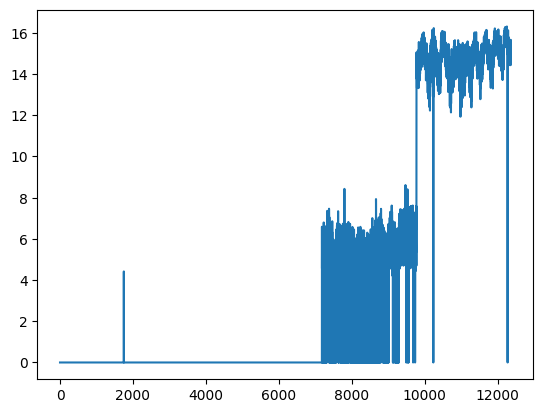

In [17]:
sns.lineplot(y_test)

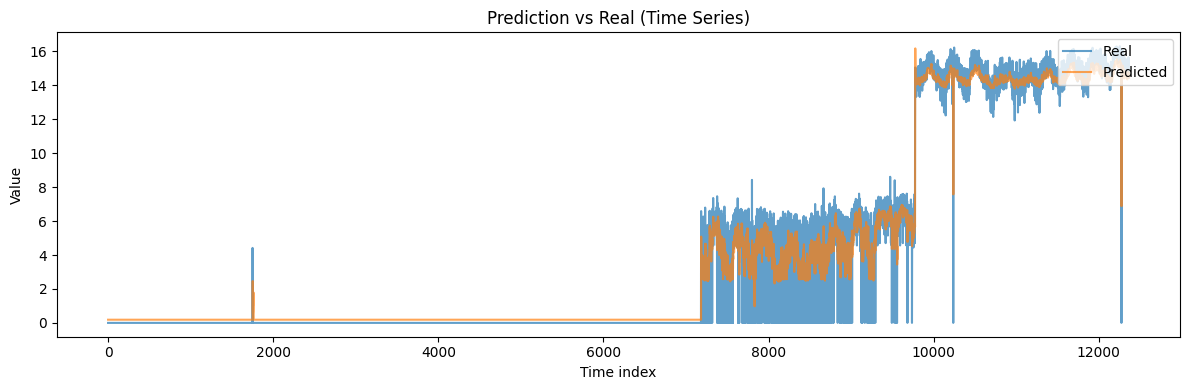

In [26]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_pred = model(X_test_tensor).cpu().numpy().ravel()

y_true = y_test.ravel()

# If you have timestamps
# time_test = test_df["time"].values
# Otherwise use index
t = range(len(y_true))

plt.figure(figsize=(12, 4))
plt.plot(t, y_true, label="Real", alpha=0.7)
plt.plot(t, y_pred, label="Predicted", alpha=0.7)

plt.title("Prediction vs Real (Time Series)")
plt.xlabel("Time index")
plt.ylabel("Value")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

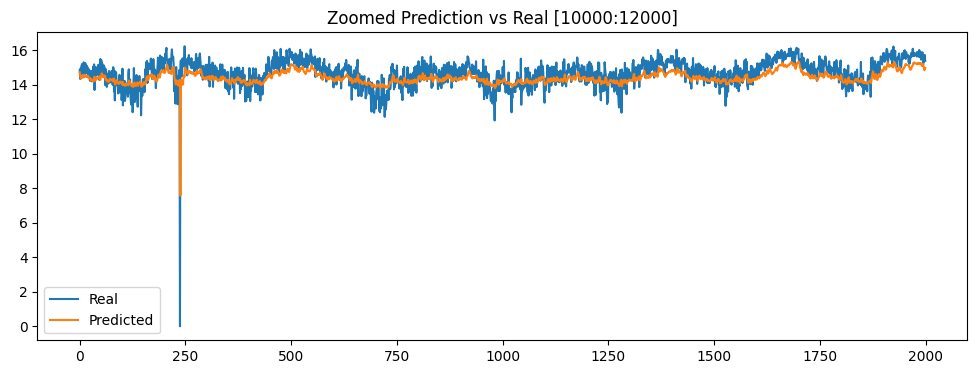

In [27]:
start = 10000
end = 12000

plt.figure(figsize=(12, 4))
plt.plot(y_true[start:end], label="Real")
plt.plot(y_pred[start:end], label="Predicted")
plt.title(f"Zoomed Prediction vs Real [{start}:{end}]")
plt.legend()
plt.show()
